# Predicting Bitcoin Prices

Recurrent neural networks (rnn) are a favorite for temporal problems, such as finding trends. The overall framework: _define_, _compile_, and _fit_ and well as assessment in _evalute_ remain the same. The rnn differences exist in the additional of layers in the define step of model building.

Note that many in the finance community believe neural nets are not the best time series analysis solution.

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cryptocmd import CmcScraper

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
SYMBOLS_BITCOIN = 'BTC'
END_DATE = '22-03-2024'
START_DATE = '01-03-2023' # '%d-%m-%Y' format
WINDOW_SIZE = 15
TRAIN_SIZE = .7

In [4]:
def create_X_y_windows(sequence, past_days):    
    ''' produces windows for rnn'''
    x, y = [], [] 
    for window in range(len(sequence)):
        past = window + past_days
        future = past + 1
        if future > len(sequence):
            break
        past_window   = sequence[window:past, :]
        future_window = sequence[past:future, -1]
        x.append(past_window)
        y.append(future_window)
    
    return np.array(x), np.array(y)

In [8]:
scraper = CmcScraper(SYMBOLS_BITCOIN, START_DATE, END_DATE)
BTC_prices = scraper.get_dataframe()

#### Preparing

In [25]:
BTC_prices.shape
BTC_prices.head(4)

(388, 11)

,Date,Open,High,Low,Close,Volume,Market Cap,Time Open,Time High,Time Low,Time Close
0,2024-03-22,65489.928460,66623.749299,62355.369708,63778.762558,4.140112e+10,1.254458e+12,2024-03-22T00:00:00.000Z,2024-03-22T06:11:00.000Z,2024-03-22T21:41:00.000Z,2024-03-22T23:59:59.999Z
1,2024-03-21,67911.583867,68199.990438,64580.916739,65491.389925,4.448035e+10,1.287575e+12,2024-03-21T00:00:00.000Z,2024-03-21T00:45:00.000Z,2024-03-21T20:05:00.000Z,2024-03-21T23:59:59.999Z
2,2024-03-20,61930.154896,68115.258866,60807.785960,67913.673025,6.679263e+10,1.335132e+12,2024-03-20T00:00:00.000Z,2024-03-20T22:17:00.000Z,2024-03-20T05:34:00.000Z,2024-03-20T23:59:59.999Z
3,2024-03-19,67556.131156,68106.927407,61536.180246,61912.773152,7.421584e+10,1.217479e+12,2024-03-19T00:00:00.000Z,2024-03-19T00:21:00.000Z,2024-03-19T23:27:00.000Z,2024-03-19T23:59:59.999Z


In [27]:
Z, z_prime = create_X_y_windows(BTC_prices[['Open']].to_numpy(), WINDOW_SIZE)

In [28]:
Z.shape

(373, 15, 1)

In [30]:
Z[1,:,:] # first 15 value 'slice'
Z[1,0,:] # first value in first window
Z[2,:,:] # second 15 value 'slice'
Z[2,0,:] # first value in second window (and second value of first window)

array([[67911.58386688],
       [61930.15489599],
       [67556.13115581],
       [68371.30726496],
       [65316.34488265],
       [69392.48750026],
       [71387.87320287],
       [73079.3733788 ],
       [71482.11706821],
       [72125.1216267 ],
       [69020.54977466],
       [68500.25585421],
       [68299.25972628],
       [66938.09348483],
       [66099.74165249]])

array([67911.58386688])

array([[61930.15489599],
       [67556.13115581],
       [68371.30726496],
       [65316.34488265],
       [69392.48750026],
       [71387.87320287],
       [73079.3733788 ],
       [71482.11706821],
       [72125.1216267 ],
       [69020.54977466],
       [68500.25585421],
       [68299.25972628],
       [66938.09348483],
       [66099.74165249],
       [63776.0514258 ]])

array([61930.15489599])

In [26]:
scaler = MinMaxScaler()
data_scaled_np = scaler.fit_transform(BTC_prices[['Open']]) # now numpy

In [11]:
X, y_prime = create_X_y_windows(data_scaled_np, WINDOW_SIZE)
y=y_prime[:,0] # from single column to vector

In [12]:
X.shape
y_prime.shape
y.shape

(373, 15, 1)

(373, 1)

(373,)

In [13]:
X[1,:,:]
X[1,0,:] # first value in first window
X[2,0,:] # first value in second window (and second value of first window)

array([[0.90229451],
       [0.78920584],
       [0.8955741 ],
       [0.91098633],
       [0.85322729],
       [0.93029341],
       [0.96801943],
       [1.        ],
       [0.96980126],
       [0.98195831],
       [0.92326132],
       [0.91342431],
       [0.90962416],
       [0.88388909],
       [0.86803868]])

array([0.90229451])

array([0.78920584])

In [14]:
array_split_index = int(X.shape[0] * TRAIN_SIZE) 

In [15]:
X_train, X_test = np.array_split(X, [array_split_index])
y_train, y_test = np.array_split(y, [array_split_index])

In [16]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(261, 15, 1)

(112, 15, 1)

(261,)

(112,)

#### Modeling

In [17]:
# define RNN model
model = Sequential()

model.add(SimpleRNN(1)) # Tensorflow will figure out input shape

model.add(Dense(50, activation='relu'))
model.add(Dense(1)) # default activation='linear', one node for mse

2024-03-24 17:58:49.337152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-24 17:58:49.337187: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-24 17:58:49.337213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-073a5ba6-5e7f-487e-b570-b959ffadafe0): /proc/driver/nvidia/version does not exist
2024-03-24 17:58:49.337483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [19]:
# fit the model
history = model.fit(X_train, y_train, epochs=12, verbose=1) 

Epoch 1/12
9/9 [==============================] - 1s 4ms/step - loss: 0.1877 - mse: 0.1877
Epoch 2/12
9/9 [==============================] - 0s 10ms/step - loss: 0.1116 - mse: 0.1116
Epoch 3/12
9/9 [==============================] - 0s 8ms/step - loss: 0.0632 - mse: 0.0632
Epoch 4/12
9/9 [==============================] - 0s 3ms/step - loss: 0.0390 - mse: 0.0390
Epoch 5/12
9/9 [==============================] - 0s 8ms/step - loss: 0.0285 - mse: 0.0285
Epoch 6/12
9/9 [==============================] - 0s 3ms/step - loss: 0.0263 - mse: 0.0263
Epoch 7/12
9/9 [==============================] - 0s 8ms/step - loss: 0.0257 - mse: 0.0257
Epoch 8/12
9/9 [==============================] - 0s 3ms/step - loss: 0.0254 - mse: 0.0254
Epoch 9/12
9/9 [==============================] - 0s 9ms/step - loss: 0.0248 - mse: 0.0248
Epoch 10/12
9/9 [==============================] - 0s 3ms/step - loss: 0.0243 - mse: 0.0243
Epoch 11/12
9/9 [==============================] - 0s 8ms/step - loss: 0.0236 - mse: 0.0

#### Evaluating

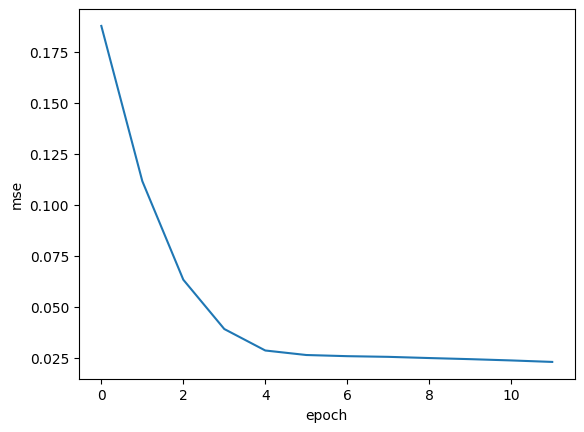

In [20]:
plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(history.history['loss']);

Note the use of `scaler.inverse_transform()`. To predict a meaningful value, we need the data scale in its original scale.

In [21]:
# predicting y_test values
scaled_predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(scaled_predicted_values)
predicted_values[0:10]

4/4 [==============================] - 0s 5ms/step


array([[35486.61 ],
       [35071.86 ],
       [34730.867],
       [34553.887],
       [34403.836],
       [34146.285],
       [33870.28 ],
       [33855.22 ],
       [33840.02 ],
       [33835.543]], dtype=float32)

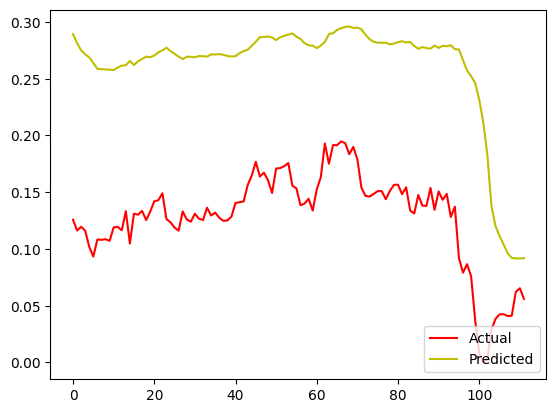

In [22]:
#plt.figure(figsize=(30,8))
plt.plot(y_test,color='r')
plt.plot(scaled_predicted_values,color='y')
plt.legend(['Actual','Predicted'],loc='lower right');

In [23]:
#BTC_prices2 = scraper.get_dataframe()
#BTC_prices=BTC_prices2[::-1]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=073a5ba6-5e7f-487e-b570-b959ffadafe0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>